# Exploratory Data Analysis

## Environment and Dataset Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# import data from csv
df = pd.read_csv('data/homes.csv')
df.head()

,Status,MLS#,Property Type,County,Style,Year Built,Master on Main,Rooms,Kitchen,Interior,...,Other,Sprinkler,Veranda,Water Feature,City,State,Zip,Latitude,Longitude,Result_Addy
0,Active,9078099,Rental,DeKalb,Brick 4 Side Ranch,1954.0,Yes,Family Room,Breakfast Room,Other Master On Main Level,...,0,0,0,0,Avondale Estates,GA,30002,-84.25691,33.770443,"3262 MAJESTIC CIR, AVONDALE EST, GA, 30002"
1,Active,20009151,Rental,Fulton,European,1999.0,Yes,Foyer Keeping Room Laundry Bonus Room Exercise...,NaN,High Ceilings Double Vanity Beamed Ceilings Tw...,...,0,0,0,0,Alpharetta,GA,30004,NaN,NaN,NaN
2,New,20010927,Rental,Fulton,European Traditional,1997.0,No,Exercise Room Family Room Foyer Great Room Kee...,NaN,High Ceilings Two Story Foyer Tile Bath Walk-I...,...,0,0,0,0,Alpharetta,GA,30004,-84.26803,34.137955,"14595 CREEK CLUB DR, ALPHARETTA, GA, 30004"
3,Pending Approval,10005432,Rental,Fulton,Traditional,1990.0,No,Foyer Laundry Family Room Other,Breakfast Area Breakfast Bar Breakfast Room Pa...,Vaulted Ceiling(s) Double Vanity Pulldown Atti...,...,0,0,0,0,Alpharetta,GA,30004,-84.34001,34.075980,"12090 WALLACE WOODS LN, ALPHARETTA, GA, 30004"
4,Active,10009045,Rental,Forsyth,Brick 3 Side Craftsman,2009.0,No,Foyer Laundry Office,Breakfast Area Breakfast Bar Breakfast Room Ki...,Bookcases Tray Ceiling(s) High Ceilings Double...,...,0,0,0,0,Alpharetta,GA,30004,-84.24270,34.125890,"3046 HIGHLAND PASS, ALPHARETTA, GA, 30004"


In [3]:
# dimensionality of dataset
print(f'{len(df.columns)} columns, {len(df)} rows')

# how many non-NaN datapoints in each column
notna_cols = df.notna().sum(axis=0)
#print(notna_cols)

# how many non-NaN datapoints in each row
notna_rows = df.notna().sum(axis=1)
#print(notna_rows)

# how many full rows and columns (no NaNs)?
print(f'{notna_rows.value_counts()[50]} full rows')
print(f'{notna_cols.value_counts()[33740]} full columns')
print()
print(notna_rows.value_counts()) #outputs in format (num values | num rows)

50 columns, 33740 rows
7591 full rows
32 full columns

50    7591
49    7251
48    6809
47    5587
46    3886
45    1459
44     623
43     372
42      98
41      45
40      19
dtype: int64


## Initial Exploration

In [4]:
# view columns of dataset and their unique values
uniques = pd.DataFrame()
for col in df.columns:
    uniques[col] = list(df[col].unique()) + ['-']*(len(df) - len(df[col].unique()))

# view number of unique values for each column
num_uniques = pd.DataFrame()
for col in df.columns:
    num_uniques[col] = [len(df[col].unique())]

## Data Cleaning and Preprocessing

In [5]:
# useful functions for keyword splitting

def flatten(lst): # flatten list of lists into single 1D list
    return [item for sub in lst for item in sub]

def remove(lst, val): # remove all instances of val from lst
    return list(filter(lambda x: x != val, lst))

def check_complete(col, keywords): # for manual extraction, check if all keywords listed (didn't miss any)
    res = ''
    for s in df[col].fillna(' '):
        op = s
        for kw in keywords:
          op = op.replace(kw, '')
        res += op
    if (checkstr := res.replace(',', '').strip()) ==  '': # if anything other than '' and ',' in output, a keyword was missed
        return True
    else:
        return checkstr


In [6]:
# split the entries of description-based columns into keywords and save in dictionary
types = {}

# Style
style_types = ['Brick 4 Side', 'Brick 3 Side', 'Ranch', 'Traditional', 'European', 'Craftsman', 'Brick Front', 'Contemporary',
'Other', 'Bungalow/Cottage', 'Brick/Frame', 'A-frame', 'Cape Cod', 'Country/Rustic', 'Colonial', 'Victorian', 'Stone Frame',
'French Provincial', 'Cluster', 'Tudor', 'Modular Home', 'Mediterranean', 'Adirondack']
# print(check_complete('Style', style_types))
types['Style'] = style_types

# Rooms
room_types = ['Keeping', 'Game', 'Great', 'Sun', 'Library', 'Den', 'Other', 'Laundry', 'Foyer', 'Exercise', 
'Family', 'Loft', 'Media', 'Office', 'Bonus']
# room_types = list(set(flatten([remove(s.replace(',', '').split(' '), 'Room') for s in df['Rooms'].fillna(' ')])) - set([''])) # automated
# print(check_complete('Rooms', room_types))
types['Rooms'] = room_types

# Kitchen
kitchen_types = ['Breakfast Bar', 'Breakfast Area', 'Pantry', 'Solid Surface Counters', 
'Breakfast Room', 'Kitchen Island', 'Walk-in Pantry', 'Second Kitchen', 'Country Kitchen']
# print(check_complete('Kitchen', kitchen_types))
types['Kitchen'] = kitchen_types

# Interior
interior_types = ['Other', 'Master On Main Level', 'High Ceilings', 'Double Vanity', 'Beamed Ceilings', 
'Two Story', 'Foyer', 'Rear Stairs', 'Separate Shower', 'Walk-In Closet(s)', 'Whirlpool Bath', 'In-Law Floorplan',
'Tile Bath', 'Wine Cellar', 'Soaking Tub', 'Pulldown Attic Stairs', 'Roommate Plan', 'Vaulted Ceiling(s)', 
'Tray Ceiling(s)', 'Bookcases', 'Split Bedroom Plan', 'Central Vacuum', 'Wet Bar', 'Sauna', 'Attic Expandable', 'Split']
# print(check_complete('Interior', interior_types))
types['Interior'] = interior_types

# Heating
heating_types = ['Forced Air', 'Natural Gas', 'Central', 'Zoned', 'Propane', 'Other', 'Electric', 'Heat Pump', 'Hot Water', 
'Dual', 'Common', 'Baseboard', 'Floor Furnace', 'Wood', 'None', 'Oil', 'Steam']
# print(check_complete('Heating', heating_types))
types['Heating'] = heating_types

# Cooling
cooling_types = ['Ceiling Fan(s)', 'Central Air', 'Electric', 'Zoned', 'Other', 'Dual', 'Common', 'Heat Pump', 'Gas', 'None',
'Attic Fan', 'Whole House Fan', 'Window Unit(s)']
# print(check_complete('Cooling', cooling_types))
types['Cooling'] = cooling_types

# Construction
construction_types = ['Stucco', 'Stone', 'Brick', 'Wood Siding', 'Vinyl Siding', 'Other', 'Concrete', 'Rough-Sawn Lumber',
'Aluminum Siding', 'Press Board', 'Steel Siding', 'Block', 'Synthetic', 'Log']
# print(check_complete('Construction', construction_types))
types['Construction'] = construction_types

# Roof
roof_types = ['Composition', 'Metal', 'Other', 'Concrete', 'Tile', 'Tar/Gravel', 'Slate', 'Wood', 'Tin']
# print(check_complete('Roof', roof_types))
types['Roof'] = roof_types

# Parking
parking_types = ['Garage Door Opener', 'Carport', 'Assigned', 'None', 'Kitchen Level', 'Off Street', 'Parking Pad',
'Side/Rear Entrance', 'Detached', 'Attached', 'Over 1 Space per Unit', 'Basement', 'RV/Boat Parking', 'Guest', 'Storage', 
'Parking Shed', 'Garage']
# print(check_complete('Parking', parking_types))
types['Parking'] = parking_types

# Amenities
amenities_types = ['Pool', 'Tennis Court(s)', 'Clubhouse', 'Gated', 'Golf', 'Park', 'Fitness Center', 'Playground', 'Street Lights',
'Walk To Shopping', 'Sidewalks', 'Walk To Schools', 'Swim Team', 'Tennis Team', 'Lake', 'Walk To Public Transit', 'None', 'Guest Lodging',
'Airport/Runway', 'Stable(s)', 'Shared Dock', 'Racquetball', 'Marina', 'Retirement Community', 'Boat/Camper/Van Prkg']
# print(check_complete('Amenities', amenities_types))
types['Amenities'] = amenities_types

# Lot
lot_types = ['City Lot', 'Private', 'Level', 'None', 'Cul-De-Sac', 'Sloped', 'Open Lot', 'Corner Lot', 'Other', 'Zero Lot Line',
'Waterfall', 'Greenbelt', 'Steep Slope', 'Pasture']
# print(check_complete('Lot', lot_types))
types['Lot'] = lot_types

In [17]:
# replace those columns with new binary ones based on keywords (one-hot encoding)
def add_one_hots(type_dict):
    edf = df.drop('State', axis=1).copy(deep=True) # new, expanded dataframe
    for og_col in type_dict.keys():
        for col in type_dict[og_col]:
            # print(col) # for debugging
            # create col in dataframe
            col_values = []
            # values in col = 1 if col name in row's og_col entry else 0
            for index, row in df.iterrows():
                row_str = str(row[og_col])
                if col in row_str:
                    code = 1
                    row_str = row_str.replace(col, '')
                else:
                    code = 0
                col_values.append(code)
            edf[f'{og_col}: {col}'] = pd.Series(col_values)
        edf = edf.drop(og_col, axis=1)
    return edf

edf = add_one_hots(types)

In [18]:
# convert all columns into numerical values
# export categorical key to text file (which number corresponds to which value)
def to_nums(col):
    if type(col[3]) == str: # first full row
        unique_vals = set([u for u in col if u != '-'])
        key = {'-': pd.NA}
        with open(f'column-keys/{col.name}.txt', 'w') as file:
            for (i,v) in enumerate(unique_vals):
                file.write(f'{i} {v} \n')
                key[v] = i
        return pd.Series([key[v] for v in col])
    else:
        return col

ndf = edf.fillna('-').drop('Description', axis=1).apply(to_nums) # numerical dataframe

## Correlational Analysis

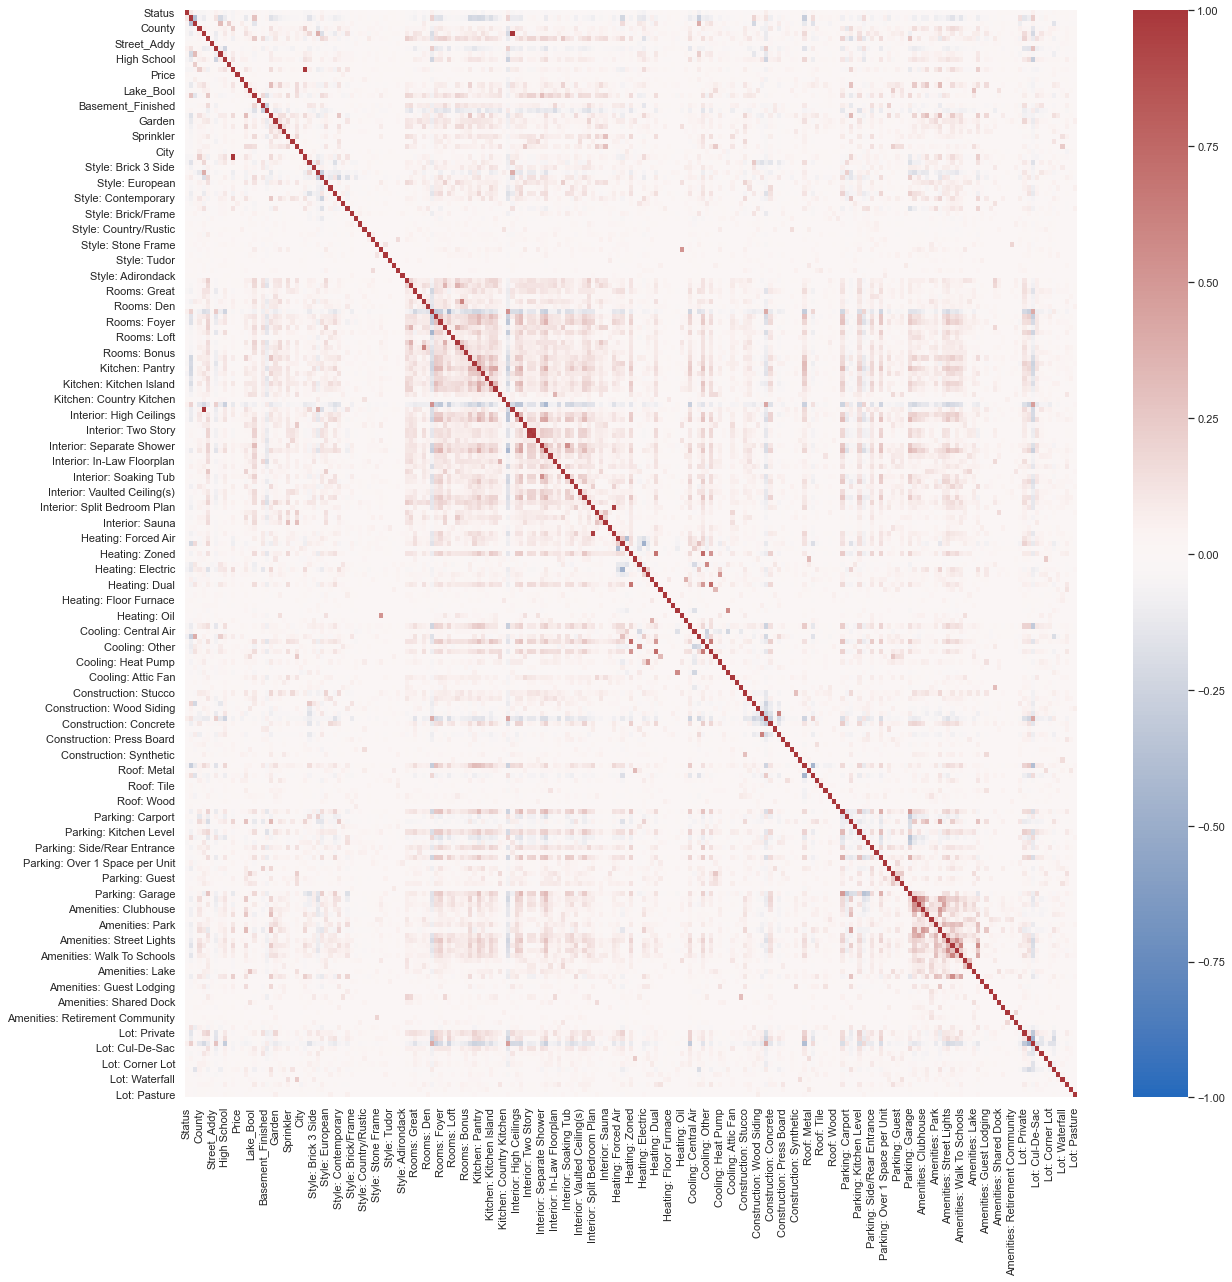

In [19]:
# correlation heatmap for all columns
corr = ndf.corr()
fig2 = plt.figure(figsize=(20,20))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='vlag')

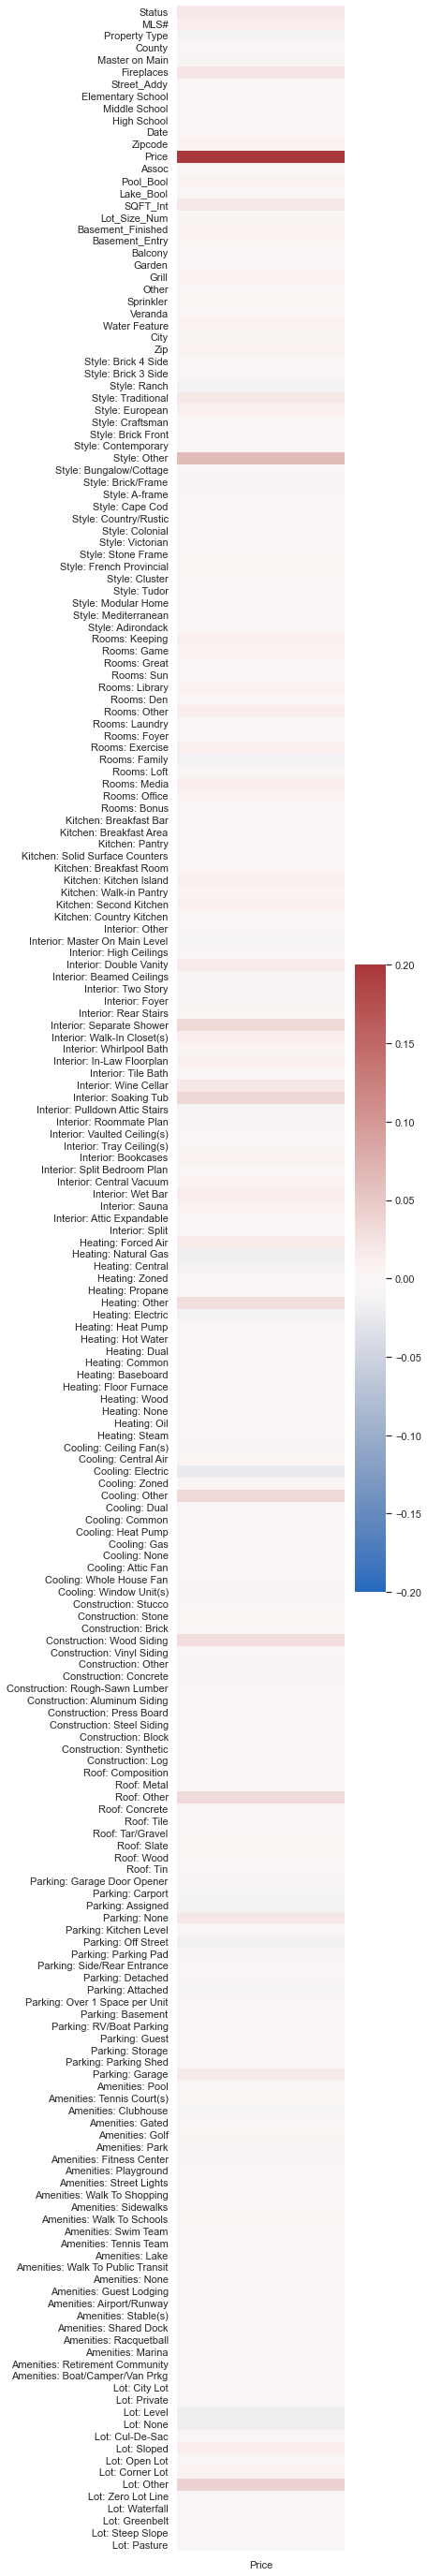

In [20]:
# correlation heatmap with focus on price
price_corr = pd.DataFrame(corr.loc['Price'])
fig3 = plt.figure(figsize=(4, 50))
price_heatmap = sns.heatmap(price_corr, vmin=-0.2, vmax=0.2, cmap='vlag')

array([[<AxesSubplot:title={'center':'Status'}>,
        <AxesSubplot:title={'center':'MLS#'}>,
        <AxesSubplot:title={'center':'Property Type'}>,
        <AxesSubplot:title={'center':'County'}>,
        <AxesSubplot:title={'center':'Master on Main'}>,
        <AxesSubplot:title={'center':'Fireplaces'}>,
        <AxesSubplot:title={'center':'Street_Addy'}>,
        <AxesSubplot:title={'center':'Elementary School'}>,
        <AxesSubplot:title={'center':'Middle School'}>,
        <AxesSubplot:title={'center':'High School'}>,
        <AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Zipcode'}>,
        <AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Assoc'}>,
        <AxesSubplot:title={'center':'Pool_Bool'}>],
       [<AxesSubplot:title={'center':'Lake_Bool'}>,
        <AxesSubplot:title={'center':'SQFT_Int'}>,
        <AxesSubplot:title={'center':'Lot_Size_Num'}>,
        <AxesSubplot:title={'center':'Basement_Finished'}>,
 

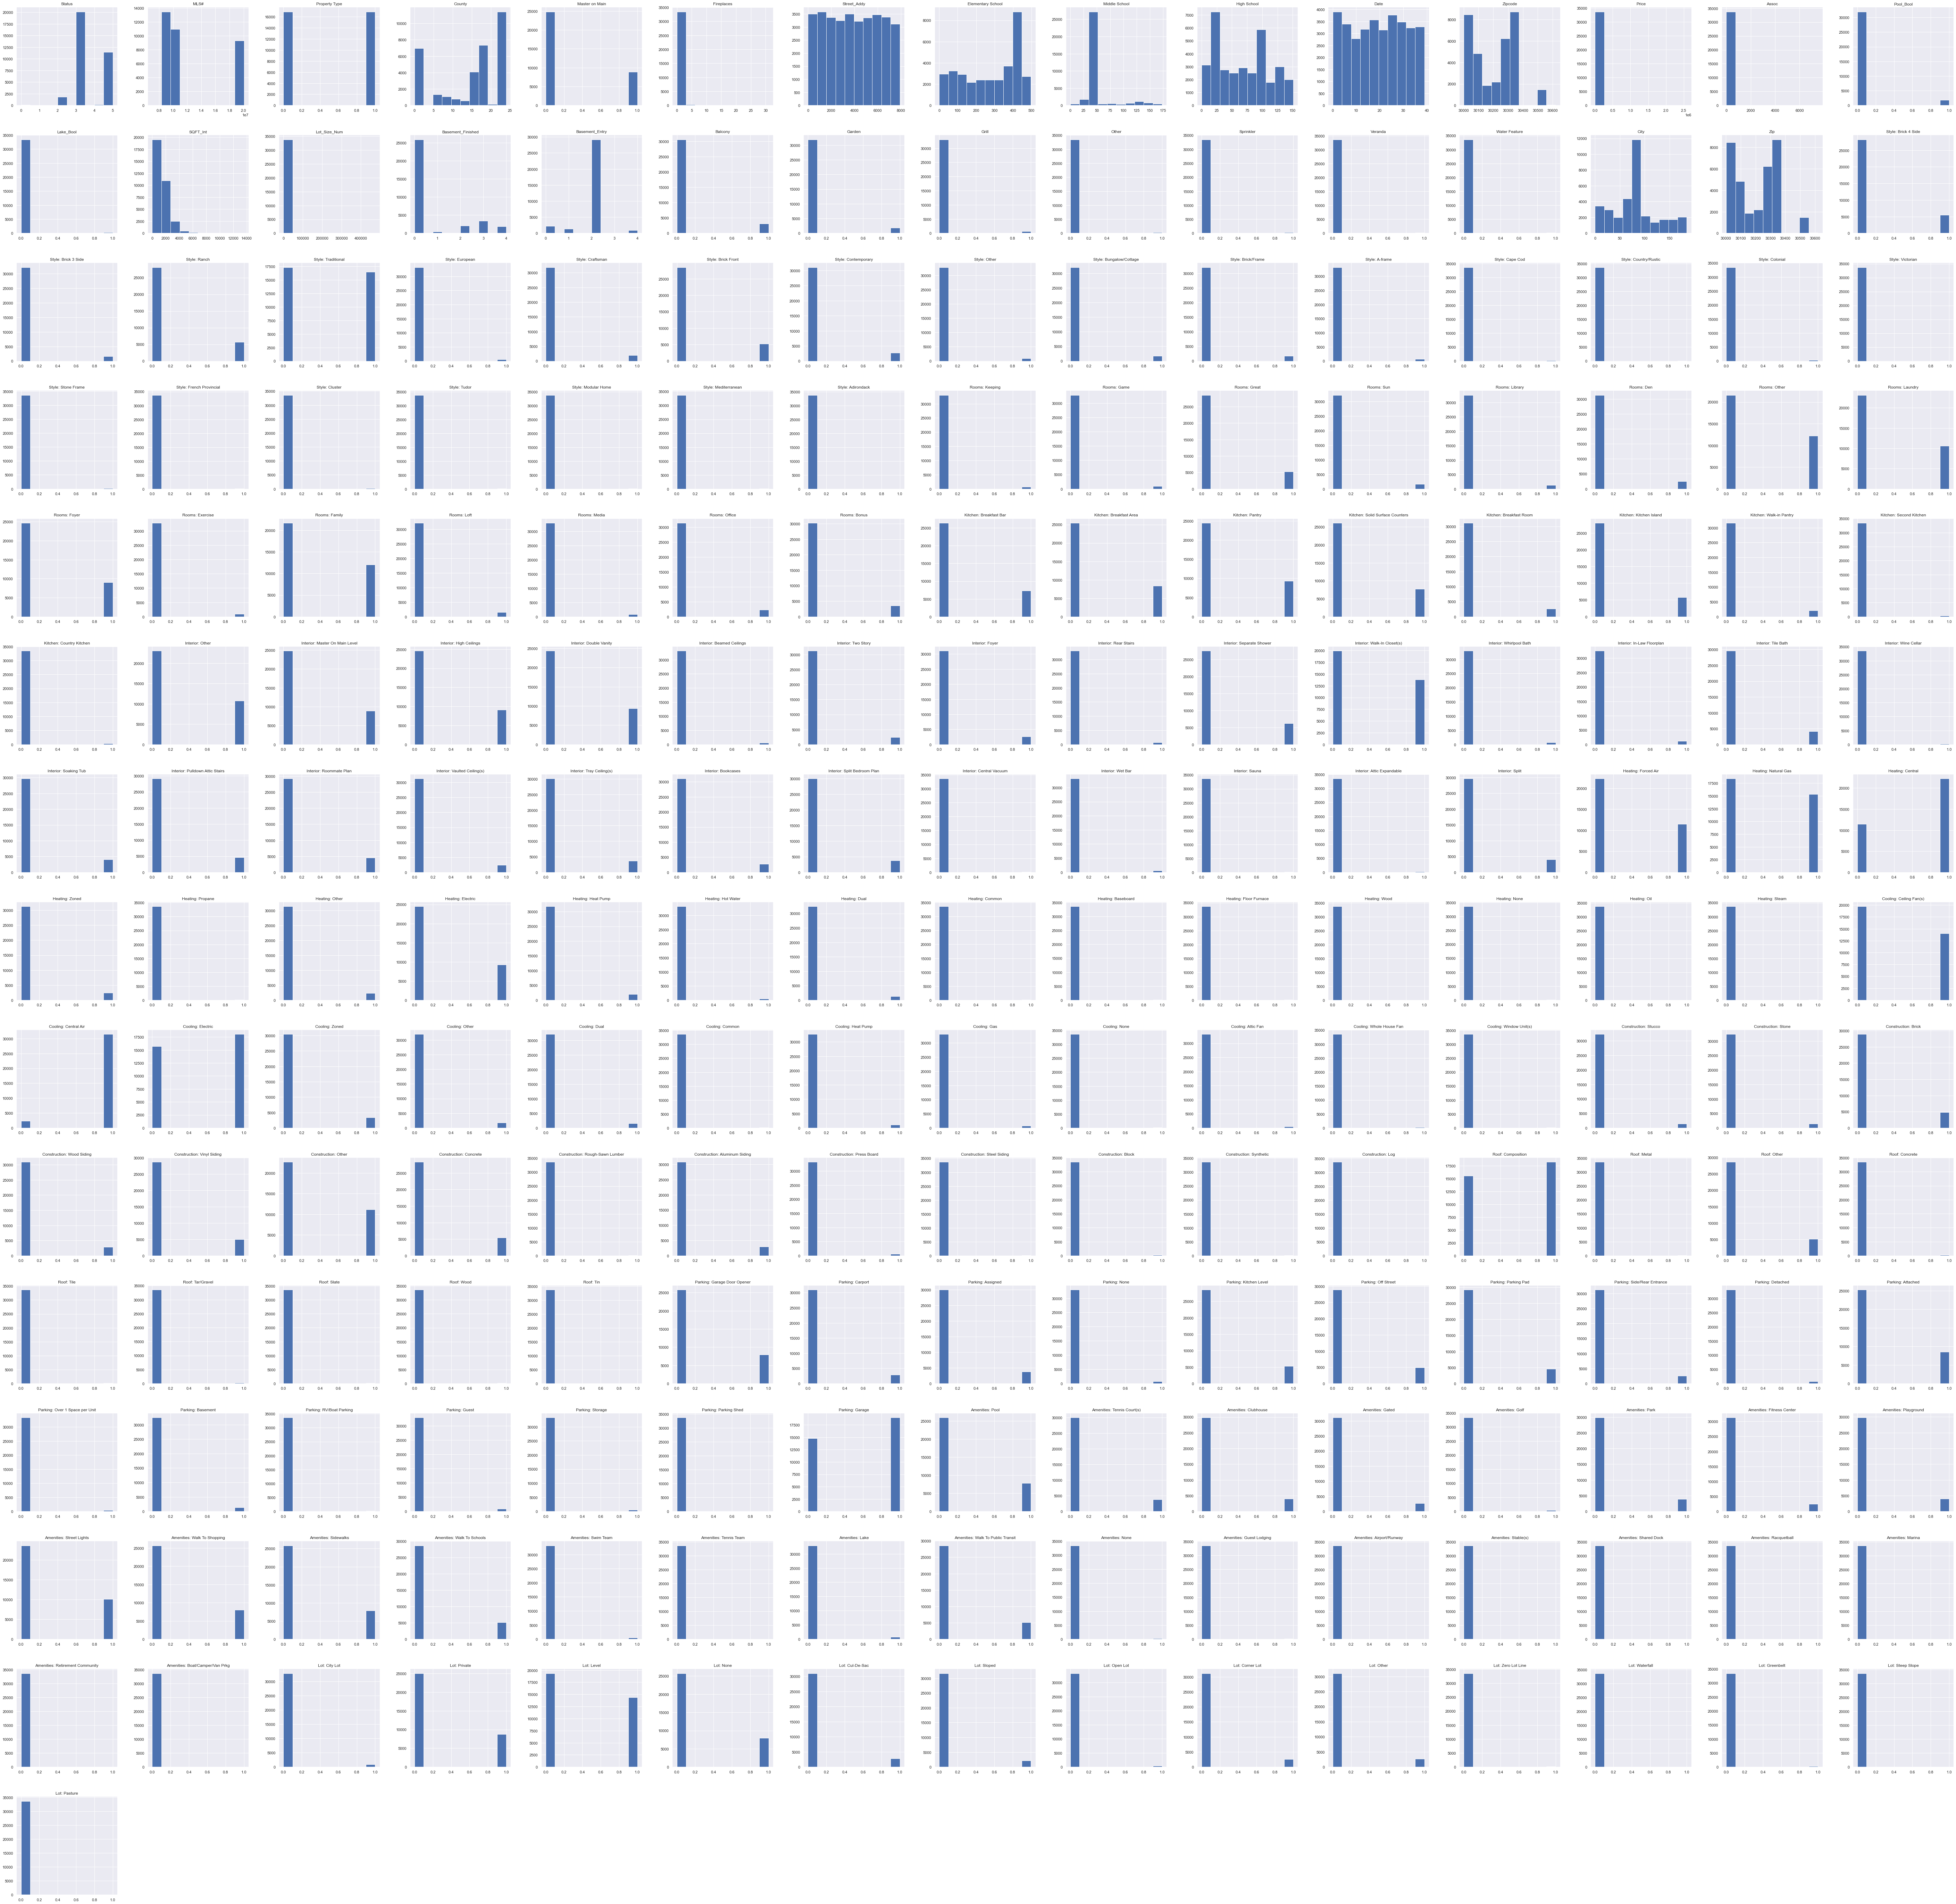

In [25]:
# histplot for each column
ndf.hist(figsize=(100,100))

In [27]:
# descriptive stats on the one-hot dataframe
edf_descr = edf.describe()